In [1]:
import torch
import torch.optim as optim

import numpy as np
import pandas as pd
import pickle
from utils.vmf_batch import vMF

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from utils.training_utils import train, evaluate

## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
with open('./data/urban_data/iterator/soma_centered/train_iterator.pkl', 'rb') as f:
    train_iterator = pickle.load(f)

with open('./data/urban_data/iterator/soma_centered/val_iterator.pkl', 'rb') as f:
    val_iterator = pickle.load(f)
   

In [4]:
src_data, trg_data, seq_len, indices, labels = list(train_iterator)[0]
bs, n_walks, walk_length, output_dim = src_data.shape

N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)

 
MASKING_ELEMENT = train_iterator.dataset.masking_el

# get number of labels, ignore -100 index
l = list(np.unique(labels))
if -100 in l:
    l.remove(-100)
NUM_CLASSES = len(l)

In [5]:
np.unique(train_iterator.dataset.labels[train_iterator.sampler.indices])

array([0])

### load model

In [6]:
emb_dim = 16
latent_dim = 8
NUM_LAYERS = 2
dpout = .1
kap = 500
pool = 'max'
lr = 0.01

#output_dim = 3
#NUM_CLASSES = 5
#n_walks=256

enc = SeqEncoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dec = SeqDecoder(output_dim, emb_dim, emb_dim, NUM_LAYERS, dpout)
dist = vMF(latent_dim, kappa=kap)
model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)

KLD: 18.465579986572266


In [7]:
def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL

In [8]:
torch.cuda.empty_cache()

In [9]:
path = "./models/5_populations"
import os 
os.makedirs(path, exist_ok=True)

In [11]:

N_EPOCHS= 200
save_path_model= './models/urban/finetuned/soma_centered/finetuned_vae_frac%.1f_best_run%i.pt'
save_path_losses = './models/urban/finetuned/soma_centered/finetuned_losses_frac%.1f_run%i.npy'
save_path_elapsed_time = './models/urban/finetuned/soma_centered/finetuned_elapsed_time_frac%.1f_run%i.npy'
state_dict = torch.load('./models/parameter_search/emb16_hid16_lat8_dp0.1_k500_avg_run1_best.pt')
# start with the 5 pop toy data, "true" finetuning on the urban data
# loads in parameters from 5 pop toy data, updates from what it learns from urban
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for frac in [1., .9, .5, .1, 0.]:
    
  
    runs = range(1,4)
        
    for run in runs:
        
        # load pre-trained model
        # the first run was the best
        model.load_state_dict(state_dict['model_state_dict'])
        classifier.apply(init_weights)
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100)
        mse_loss = torch.nn.MSELoss(reduction='sum')


        #optimizer
        optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)
       
        best_test_loss = np.infty

        losses = np.load('./models/parameter_search/losses_emb16_hid16_lat8_dp0.1_k500_avg_1.npy')
        elapsed_time = np.zeros((N_EPOCHS))
        training = list(losses[:,:2])
        validation = list(losses[:,2:])
        
        for e in range(N_EPOCHS):
            start.record()
            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, clip=1, norm_p=None,
                                                 class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)

            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val
            
            end.record()

            # Waits for everything to finish running
            torch.cuda.synchronize()
            elapsed_time[e] = start.elapsed_time(end) # milliseconds
            
            training += [[train_loss,train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}, Time elapsed [s]: {elapsed_time[e]/1000:.2f}')


            if e % 50 == 0 and e > 0:
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                torch.save({'epoch': e,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'classifier_state_dict': classifier.state_dict()
                               },save_path_model%(frac, run))

                validation_ = np.array(validation)
                training_ = np.array(training)
                # [:,0] = training loss, [:,1] = training classification loss 
                # [:,2] validation loss, [:,3] validation classification loss
                losses = np.hstack((training_, validation_))
                np.save(save_path_losses%(frac, run),losses)
                np.save(save_path_elapsed_time%(frac,run),elapsed_time)
        validation = np.array(validation)
        training = np.array(training)
        losses = np.hstack((training, validation))
        np.save(save_path_losses%(frac, run), losses)
        np.save(save_path_elapsed_time%(frac,run),elapsed_time)

| ID | GPU | MEM |
------------------
|  0 |  1% |  7% |
| ID | GPU | MEM |
------------------
|  0 |  0% | 13% |
Epoch 0, Train Loss: 40194.61, Val Loss: 79143.89, Time elapsed [s]: 8.38
| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |


KeyboardInterrupt: 

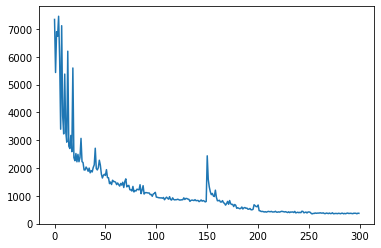

In [20]:
plt.plot(np.array(validation)[:,0])

In [23]:
elapsed_time.mean()/1000


26.72294771484375